In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_batxrt.txt'

GRBs=['050724', '051227', '060614', '061006', '061210', '070714B', '071227', '080123', '080503', '111121A', '150424A', '211211A', '211227A']

### Extracting and Plotting Curves


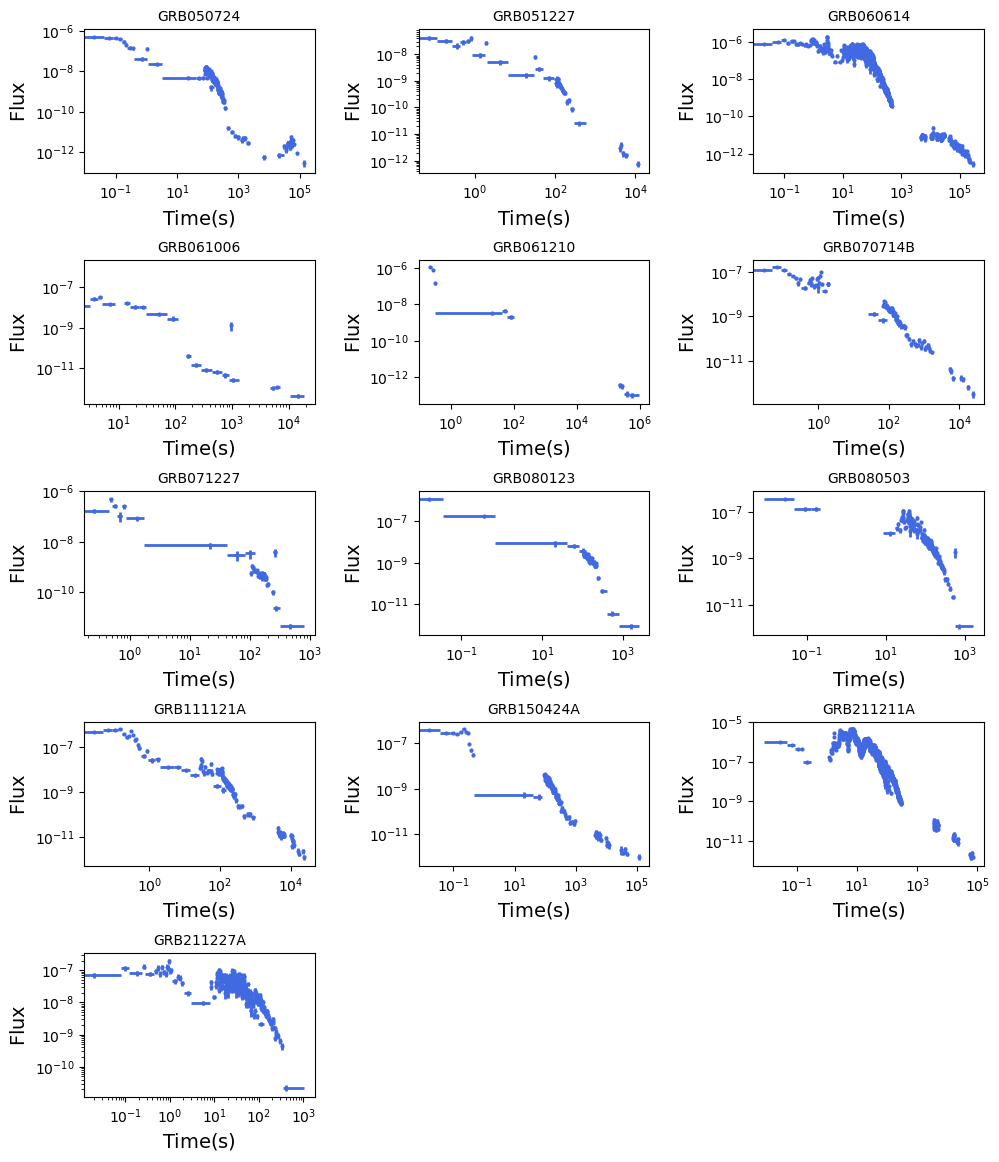

In [3]:
fig=plt.figure(figsize=(10.0,12.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.45)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(5,3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=12

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 80
    # data points      = 350
    # variables        = 4
    chi-square         = 762.866780
    reduced chi-square = 2.20481728
    Akaike info crit   = 280.702591
    Bayesian info crit = 296.134324
[[Variables]]
    tb0:        85.0000000 +/- 4.38669019 (5.16%) (init = 100)
    alpha_0:    0.36142840 +/- 0.04855611 (13.43%) (init = 2)
    alpha_1:    2.36647014 +/- 0.16102992 (6.80%) (init = 4)
    amplitude:  1.3904e-08 +/- 1.0532e-09 (7.57%) (init = 5e-08)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.7517
    C(alpha_0, amplitude) = -0.7201
    C(tb0, alpha_1)       = +0.6107
    C(tb0, alpha_0)       = +0.4466
    C(alpha_1, amplitude) = -0.1504


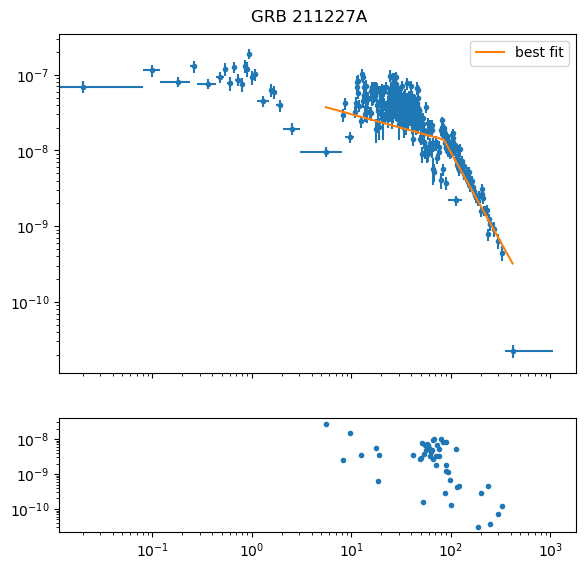

name,value,standard error,relative error,initial value,min,max,vary
tb0,85.0000000,4.38669019,(5.16%),100,85.0000000,150.000000,True
alpha_0,0.36142840,0.04855611,(13.43%),2,0.00000000,10.0000000,True
alpha_1,2.36647014,0.16102992,(6.80%),4,0.00000000,10.0000000,True
amplitude,1.3904e-08,1.0532e-09,(7.57%),5e-08,1.0000e-08,1.0000e-07,True


In [4]:
i=12
n=2
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

ee_start_index = np.where(time > 4)[0][0]
fit_end_index = np.where(time <  1e3)[0][-1]


params=lm.Parameters()
params.add("tb0", min = 85, max = 150, value = 100)
params.add("alpha_0", min = 0, max = 10.0, value = 2)
params.add("alpha_1", min = 0, max = 10.0, value =4)
params.add("amplitude", min = 1e-8, max = 1e-7, value = 5e-8)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[ee_start_index:fit_end_index], flux[ee_start_index:fit_end_index], time_err[ee_start_index:fit_end_index], flux_err[ee_start_index:fit_end_index], n))
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time[ee_start_index:fit_end_index]) - flux[ee_start_index:fit_end_index]
x=np.geomspace(time[ee_start_index], time[fit_end_index])
y = get_y(result, n, x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1], sharex=True)
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit', zorder=10)
# ax1.loglog(x,nbroken_law(x,[107], [0.5, 4], 1e-7),label ='guess')
ax1.legend()
ax2.loglog(time[ee_start_index:fit_end_index],residuals, '.')
plt.subplots_adjust(top=0.94)
plt.suptitle("GRB "+GRBs[i])
plt.show()


result.params

In [5]:
print("ee_start_index = ", ee_start_index)
print("fit_end_index = ", fit_end_index)
print("best_fit =", result.params.valuesdict())
standard_errors_dict = {param.name+"_err": param.stderr for param in result.params.values()}
print("errors =", standard_errors_dict)

ee_start_index =  21
fit_end_index =  371
best_fit = {'tb0': 85.00000000000001, 'alpha_0': 0.3614284001124204, 'alpha_1': 2.366470142082996, 'amplitude': 1.390426015881884e-08}
errors = {'tb0_err': 4.386690193315028, 'alpha_0_err': 0.04855610604016308, 'alpha_1_err': 0.16102992159125357, 'amplitude_err': 1.0532097928037002e-09}
